# H12 with sgkit

This notebook is for running a H12 scan using sgkit, to reproduce the scikit-allel one (`h12_scans.ipynb`).

You need to have run `sgkit_import_haplotypes.ipynb` first to convert the data into sgkit format.

In [1]:
%run setup.ipynb

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dask.diagnostics import ProgressBar
import sgkit as sg
import xarray as xr

First, let's inspect the input data. Note that it has a single chunk in the `samples` dimension, which is a requirement for running the popgen analyses.

In [4]:
ds = sg.load_dataset(here() / 'data/sgkit/ag1000g_haplotypes.zarr', consolidated=False)
ds

<xarray.Dataset>
Dimensions:             (variants: 39604636, samples: 1164, ploidy: 2,
                         alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, alleles
Data variables:
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    sample_id           (samples) <U8 dask.array<chunksize=(1164,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(4194304, 2), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
Attributes:
    contigs:                    ['2R', '2L', '3R', '3L']
    max_length_variant_allele:  1
    source:                     sgkit-0.6.0

## Cohorts

We need to divide the samples into separate cohorts, which we get from the `pop_defs` YAML:

In [5]:
cohort_ids = list(pop_defs.keys())
cohort_ids

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [6]:
ds["cohort_id"] = xr.DataArray(cohort_ids, dims="cohorts")
ds

<xarray.Dataset>
Dimensions:             (variants: 39604636, samples: 1164, ploidy: 2,
                         alleles: 2, cohorts: 15)
Dimensions without coordinates: variants, samples, ploidy, alleles, cohorts
Data variables:
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    sample_id           (samples) <U8 dask.array<chunksize=(1164,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(4194304, 2), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    cohort_id           (cohorts) <U10 'ao_col' 'bf_col' ... 'ke' 'ug_gam'
Attributes:
    contigs:                    ['2R', '2L', '3R', '3L']
    max_length_variant_allele:  1
    source:                     sgkit-0.6.0

Sample metadata is in the `df_samples` dataframe, so we can use that to produce a mapping from sample to cohort

In [7]:
sample_cohorts = np.full_like(ds.sample_id.values, -1, dtype=np.int8)
for i, pop in enumerate(cohort_ids):
    pop_query = (
            pop_defs[pop]['query']
            .replace('region', 'location')
            .replace('Gado-Badzere', 'Gado Badzere')
            .replace('Zembe-Borongo', 'Zembe Borongo')
    )
    loc_pop = df_samples.query(pop_query).index.values
    sample_cohorts[loc_pop] = i
sample_cohorts

array([ 7,  7,  7, ..., -1, -1, -1], dtype=int8)

Add `sample_cohort` to the dataset

In [8]:
ds["sample_cohort"] = xr.DataArray(sample_cohorts, dims="samples")
ds

<xarray.Dataset>
Dimensions:             (variants: 39604636, samples: 1164, ploidy: 2,
                         alleles: 2, cohorts: 15)
Dimensions without coordinates: variants, samples, ploidy, alleles, cohorts
Data variables:
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    sample_id           (samples) <U8 dask.array<chunksize=(1164,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(4194304, 2), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    cohort_id           (cohorts) <U10 'ao_col' 'bf_col' ... 'ke' 'ug_gam'
    sample_cohort       (samples) int8 7 7 7 7 7 8 7 8 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    contigs:                    ['2R', '2L', '3R', '3L']
    max_length_variant_allele:  1
    source:                     sgkit-0.6.0

Some samples are not in any of the named cohorts, and have -1 in the `sample_cohort` variable. These are ignored in cohort allele counts.

## Windowing

To compute popgen stats we need to set up windows along the genome. H12 actually has windows that vary according to the population cohort, but for now we'll use a fixed window size of 6000 (step size is half that).

In [9]:
ds = sg.window_by_variant(ds, size=6000, step=3000)
ds

<xarray.Dataset>
Dimensions:             (windows: 13203, variants: 39604636, samples: 1164,
                         ploidy: 2, alleles: 2, cohorts: 15)
Dimensions without coordinates: windows, variants, samples, ploidy, alleles,
                                cohorts
Data variables:
    window_contig       (windows) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
    window_start        (windows) int64 0 3000 6000 ... 39599970 39602970
    window_stop         (windows) int64 6000 9000 12000 ... 39604636 39604636
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    sample_id           (samples) <U8 dask.array<chunksize=(1164,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(4194304, 2), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    cohort_id           (cohorts) <U10 'ao_col' 'bf_col' ... 'ke' 'ug_gam'
    sample_cohort       (samples) int8 7 7 7 7 7 8 7 8 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    contigs:                    ['2R', '2L', '3R', '3L']
    max_length_variant_allele:  1
    source:                     sgkit-0.6.0

## H12

We are now in a position to calculate the H statistics. We'll restrict to the `ao_col` cohort, since it's the only one that has a window size of 6000. (Note we could have computed the stats for all cohorts by omitting the `cohorts` keyword.)

In [10]:
ds = ds.assign_coords({"cohorts": list(pop_defs)})
h = sg.Garud_H(ds, cohorts=["ao_col"])
h

<xarray.Dataset>
Dimensions:             (windows: 13203, cohorts: 15, variants: 39604636,
                         samples: 1164, ploidy: 2, alleles: 2)
Coordinates:
  * cohorts             (cohorts) <U10 'ao_col' 'bf_col' ... 'ke' 'ug_gam'
Dimensions without coordinates: windows, variants, samples, ploidy, alleles
Data variables: (12/15)
    stat_Garud_h1       (windows, cohorts) float64 dask.array<chunksize=(175, 15), meta=np.ndarray>
    stat_Garud_h12      (windows, cohorts) float64 dask.array<chunksize=(175, 15), meta=np.ndarray>
    stat_Garud_h123     (windows, cohorts) float64 dask.array<chunksize=(175, 15), meta=np.ndarray>
    stat_Garud_h2_h1    (windows, cohorts) float64 dask.array<chunksize=(175, 15), meta=np.ndarray>
    window_contig       (windows) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
    window_start        (windows) int64 0 3000 6000 ... 39599970 39602970
    ...                  ...
    sample_id           (samples) <U8 dask.array<chunksize=(1164,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(4194304, 2), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    cohort_id           (cohorts) <U10 'ao_col' 'bf_col' ... 'ke' 'ug_gam'
    sample_cohort       (samples) int8 7 7 7 7 7 8 7 8 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    contigs:                    ['2R', '2L', '3R', '3L']
    max_length_variant_allele:  1
    source:                     sgkit-0.6.0

In [11]:
with ProgressBar():
    h = h.chunk({"windows": 175}) # rechunk to uniform window sizes so we can save to zarr
    sg.save_dataset(h, here() / 'data/sgkit/ag1000g_h12_ao_col.zarr', mode="w")

[########################################] | 100% Completed | 270.98 s


Load the dataset to have a look at it.

In [12]:
h = sg.load_dataset(here() / 'data/sgkit/ag1000g_h12_ao_col.zarr')
h = h.assign_coords({"cohorts": list(pop_defs)})
h

<xarray.Dataset>
Dimensions:             (variants: 39604636, samples: 1164, ploidy: 2,
                         cohorts: 15, windows: 13203, alleles: 2)
Coordinates:
  * cohorts             (cohorts) <U10 'ao_col' 'bf_col' ... 'ke' 'ug_gam'
Dimensions without coordinates: variants, samples, ploidy, windows, alleles
Data variables: (12/15)
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(524288, 1164, 2), meta=np.ndarray>
    cohort_id           (cohorts) <U10 dask.array<chunksize=(15,), meta=np.ndarray>
    sample_cohort       (samples) int8 dask.array<chunksize=(1164,), meta=np.ndarray>
    sample_id           (samples) <U8 dask.array<chunksize=(1164,), meta=np.ndarray>
    stat_Garud_h1       (windows, cohorts) float64 dask.array<chunksize=(175, 15), meta=np.ndarray>
    ...                  ...
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(4194304, 2), meta=np.ndarray>
    variant_contig      (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(4194304,), meta=np.ndarray>
    window_contig       (windows) int64 dask.array<chunksize=(175,), meta=np.ndarray>
    window_start        (windows) int64 dask.array<chunksize=(175,), meta=np.ndarray>
    window_stop         (windows) int64 dask.array<chunksize=(175,), meta=np.ndarray>
Attributes:
    contigs:                    ['2R', '2L', '3R', '3L']
    max_length_variant_allele:  1
    source:                     sgkit-0.6.0

In [13]:
from sgkit.window import window_statistic
window_centre_pos = window_statistic(ds.variant_position, lambda v: (v[0] + v[-1])/2, ds.window_start.values, ds.window_stop.values, dtype=float)
window_centre_pos.compute()

array([3.51430000e+04, 6.34740000e+04, 8.82055000e+04, ...,
       4.19099465e+07, 4.19309085e+07, 4.19484615e+07])

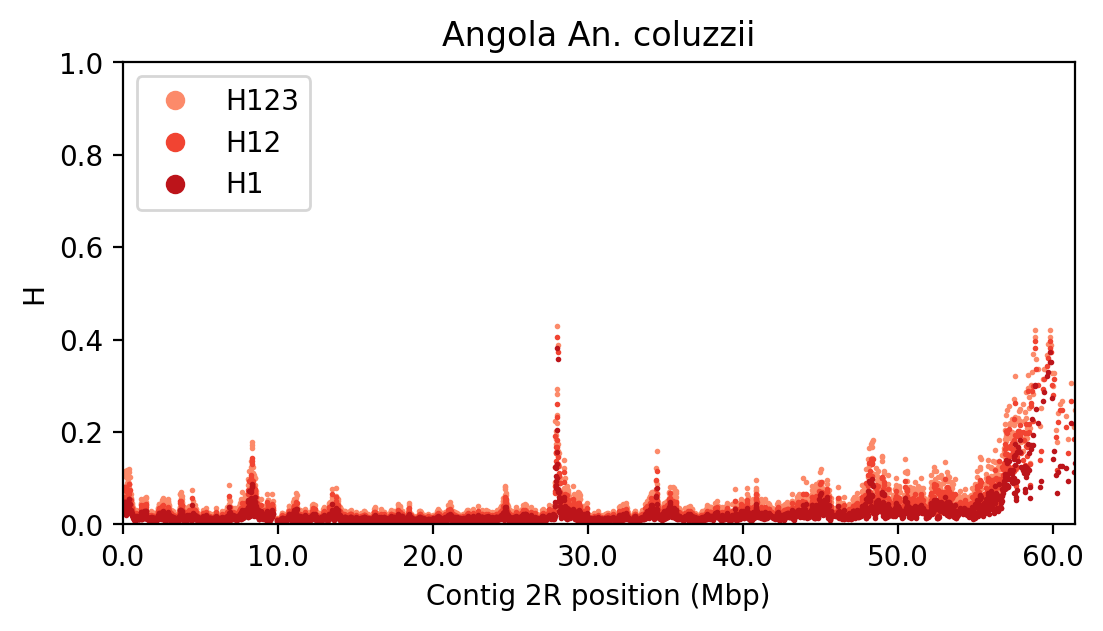

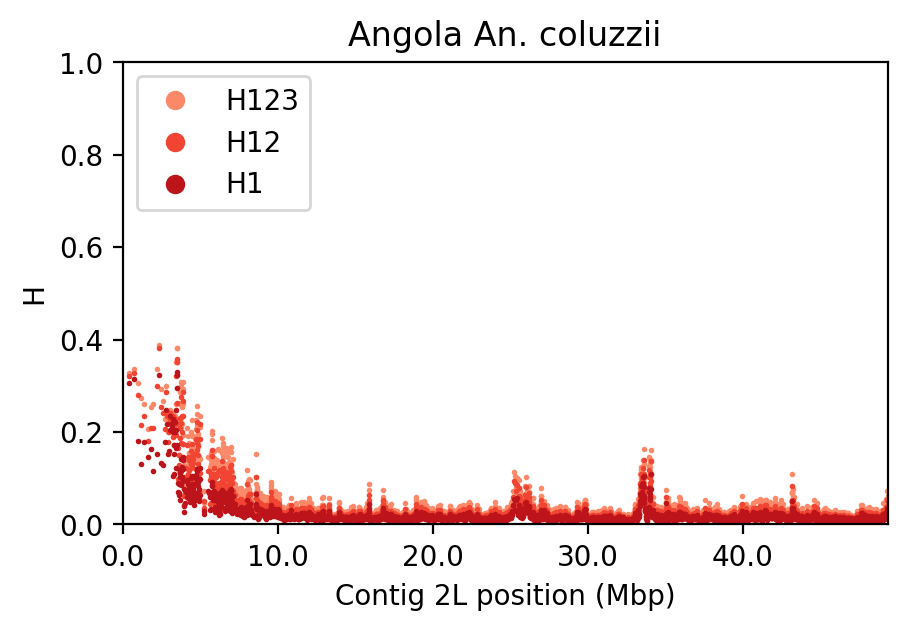

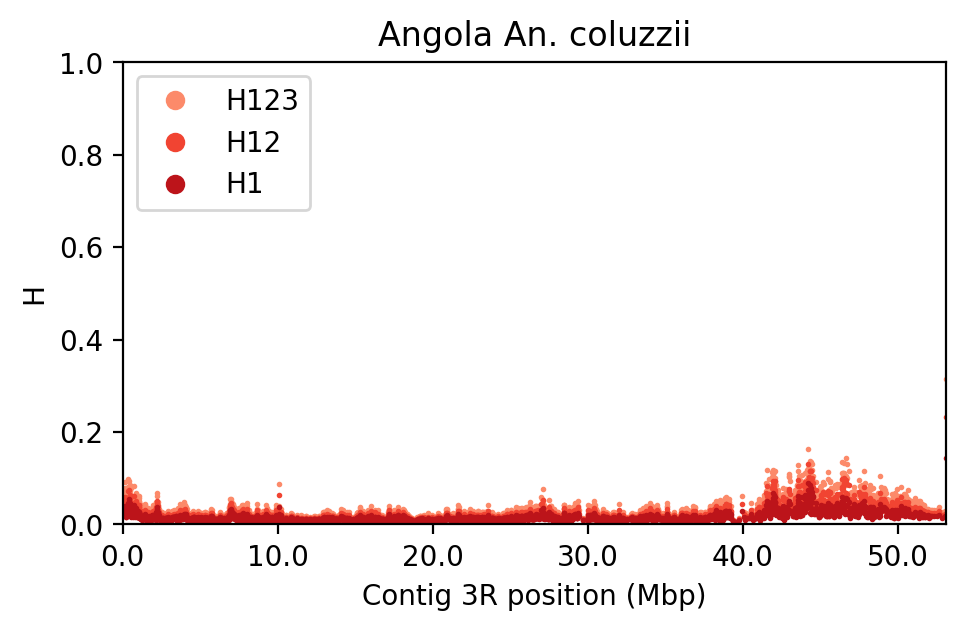

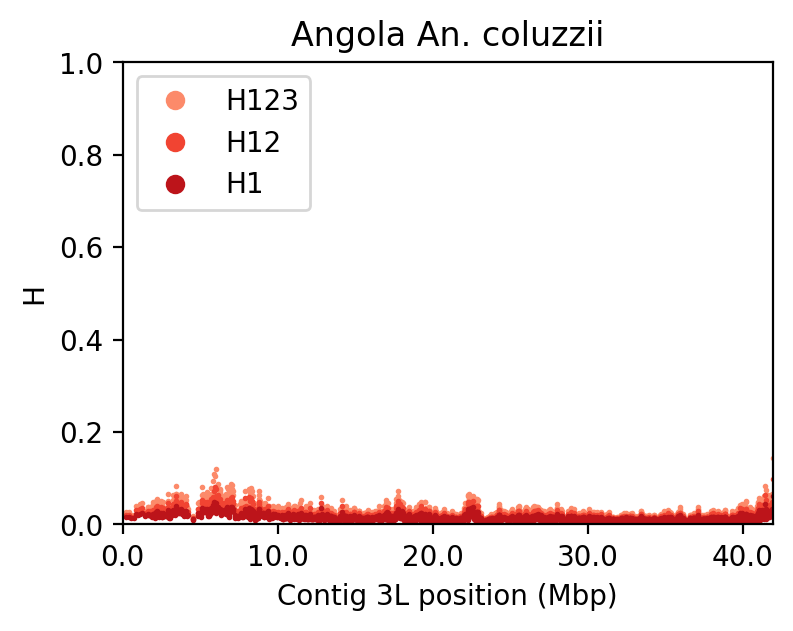

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_h_stats(pop, contig):
    contig_index = h.attrs["contigs"].index(contig)

    x = window_centre_pos.compute()[h["window_contig"] == contig_index]
    stat_h1 = h["stat_Garud_h1"].sel(cohorts=pop)[h["window_contig"] == contig_index].values
    stat_h12 = h["stat_Garud_h12"].sel(cohorts=pop)[h["window_contig"] == contig_index].values
    stat_h123 = h["stat_Garud_h123"].sel(cohorts=pop)[h["window_contig"] == contig_index].values

    figwidth = x.max()/1e7
    palette = sns.color_palette("Reds", 4)[1:]

    fig, ax = plt.subplots(facecolor='w', figsize=(figwidth, 3))
    ax.plot(x, stat_h123, linestyle=' ', marker='o', color=palette[0], markersize=1, label='H123')
    ax.plot(x, stat_h12, linestyle=' ', marker='o', color=palette[1], markersize=1, label='H12')
    ax.plot(x, stat_h1, linestyle=' ', marker='o', color=palette[2], markersize=1, label='H1')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks/1e6)
    ax.set_xlabel(f'Contig {contig} position (Mbp)')
    ax.set_ylabel('H')
    ax.set_xlim(0, x.max())
    ax.set_ylim(0, 1)
    ax.set_title(f"{pop_defs[pop]['label']}")
    ax.legend(loc='upper left', markerscale=6)
    
plot_h_stats("ao_col", "2R")
plot_h_stats("ao_col", "2L")
plot_h_stats("ao_col", "3R")
plot_h_stats("ao_col", "3L")

Have a look at the H12 values for a given cohort, to visually check concordance with scikit-allel, see https://github.com/tomwhite/shiny-train/blob/sgkit/notebooks/gwss/sgkit_h12.ipynb

In [15]:
stat_h12 = h["stat_Garud_h12"].sel(cohorts="ao_col")[:100].values
stat_h12

array([0.03591387, 0.04511834, 0.0591716 , 0.08144313, 0.08136095,
       0.07569034, 0.05136423, 0.02514793, 0.03131164, 0.05530901,
       0.07166338, 0.07618343, 0.04791256, 0.06204799, 0.07240302,
       0.05481591, 0.05613083, 0.06804734, 0.06780079, 0.06517094,
       0.08793557, 0.08694938, 0.05374753, 0.04092702, 0.04322814,
       0.07363577, 0.04413215, 0.03640697, 0.0433925 , 0.03714661,
       0.046762  , 0.03813281, 0.03295529, 0.03690007, 0.05193951,
       0.04133794, 0.03131164, 0.03369494, 0.03525641, 0.02638067,
       0.02966798, 0.02777778, 0.02169625, 0.02473702, 0.0190664 ,
       0.02095661, 0.01734057, 0.01569691, 0.01840894, 0.01816239,
       0.01545036, 0.01405325, 0.01084813, 0.00920447, 0.01158777,
       0.01881986, 0.01783366, 0.01791584, 0.01857331, 0.01454635,
       0.01536818, 0.01487508, 0.01840894, 0.02539448, 0.01964168,
       0.01454635, 0.01692965, 0.0176693 , 0.02276463, 0.01939513,
       0.01619001, 0.01873767, 0.01602564, 0.01602564, 0.01931

In [16]:
import numpy as np
np.testing.assert_allclose(stat_h12[:5], [0.03591387, 0.04511834, 0.0591716 , 0.08144313, 0.08136095])